In [13]:
suppressPackageStartupMessages({
    library(GEOquery)
    library(edgeR)
    library(dplyr)
    library(biomaRt)
    library(ggplot2)
    library(reshape2)
    library(hugene10stprobeset.db)
    library(tidyr)
    library(stringr)
})

In [2]:
# Download GEO data
gse <- getGEO("GSE57178", GSEMatrix = TRUE)
exprSet <- exprs(gse[[1]])
head(exprSet)

Found 1 file(s)

GSE57178_series_matrix.txt.gz



,GSM1376737,GSM1376738,GSM1376739,GSM1376740,GSM1376741,GSM1376742,GSM1376743,GSM1376744,GSM1376745,GSM1376746,GSM1376747,GSM1376748,GSM1376749,GSM1376750,GSM1376751,GSM1376752,GSM1376753,GSM1376754
7892501,6.46686,5.80707,6.18706,6.12905,6.00000,6.38717,5.87161,5.55011,5.43289,4.87511,6.71900,6.36994,5.99168,6.05723,6.29622,6.07141,5.58017,6.58692
7892502,6.23867,5.45787,5.54593,5.70058,5.88025,5.46561,5.40016,5.70585,5.89744,5.85964,5.74370,5.97921,5.45791,5.59953,5.57489,5.67623,5.36112,5.68307
7892503,4.22012,4.70004,4.16694,4.29442,4.23937,4.26177,4.44598,3.89638,4.13304,4.54395,4.31386,4.18171,4.49276,3.94544,4.59157,4.21806,5.10309,4.19518
7892504,9.17712,9.23920,9.04600,9.05245,9.40533,9.73973,8.86919,9.33503,9.33948,9.26910,9.17750,9.16691,9.37063,9.21811,9.23594,9.66123,9.09848,9.19735
7892505,5.23201,5.26065,4.62539,5.27837,4.85971,5.41090,5.34409,4.71479,5.27633,4.75232,4.98828,4.88814,5.04073,5.12542,4.93100,5.08791,5.23171,4.92252
7892506,4.14614,3.80165,3.85133,3.90198,3.96003,4.15932,3.76416,3.72104,3.50456,3.94329,4.17497,4.34645,3.97638,3.95167,4.18404,3.84538,4.08420,4.24203


In [33]:
mapping <- read.delim("mapping.txt.gz", header = TRUE, skip = 12)
mapping$gene_assignment <- str_extract(mapping$gene_assignment, "(?<=//)[^/]*(?=//)")
mapping <- as.data.frame(mapping$gene_assignment)
head(mapping)

,mapping$gene_assignment
,<chr>
1,NA
2,OR4G2P
3,OR4F4
4,LOC728323
5,OR4F29
6,MT-TM


In [34]:
mapping$RowIndex <- seq_len(nrow(mapping))

exprSet <- as.data.frame(exprSet)
exprSet$RowIndex <- seq_len(nrow(exprSet))

In [35]:
counts <- left_join(mapping, exprSet, by = "RowIndex") %>% dplyr::select(-RowIndex)
head(counts)

,mapping$gene_assignment,GSM1376737,GSM1376738,GSM1376739,GSM1376740,GSM1376741,GSM1376742,GSM1376743,GSM1376744,GSM1376745,GSM1376746,GSM1376747,GSM1376748,GSM1376749,GSM1376750,GSM1376751,GSM1376752,GSM1376753,GSM1376754
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,6.46686,5.80707,6.18706,6.12905,6.00000,6.38717,5.87161,5.55011,5.43289,4.87511,6.71900,6.36994,5.99168,6.05723,6.29622,6.07141,5.58017,6.58692
2,OR4G2P,6.23867,5.45787,5.54593,5.70058,5.88025,5.46561,5.40016,5.70585,5.89744,5.85964,5.74370,5.97921,5.45791,5.59953,5.57489,5.67623,5.36112,5.68307
3,OR4F4,4.22012,4.70004,4.16694,4.29442,4.23937,4.26177,4.44598,3.89638,4.13304,4.54395,4.31386,4.18171,4.49276,3.94544,4.59157,4.21806,5.10309,4.19518
4,LOC728323,9.17712,9.23920,9.04600,9.05245,9.40533,9.73973,8.86919,9.33503,9.33948,9.26910,9.17750,9.16691,9.37063,9.21811,9.23594,9.66123,9.09848,9.19735
5,OR4F29,5.23201,5.26065,4.62539,5.27837,4.85971,5.41090,5.34409,4.71479,5.27633,4.75232,4.98828,4.88814,5.04073,5.12542,4.93100,5.08791,5.23171,4.92252
6,MT-TM,4.14614,3.80165,3.85133,3.90198,3.96003,4.15932,3.76416,3.72104,3.50456,3.94329,4.17497,4.34645,3.97638,3.95167,4.18404,3.84538,4.08420,4.24203


In [37]:
counts <- left_join(mapping, exprSet, by = "RowIndex") %>% 
  dplyr::select(-RowIndex)%>%
  filter(`mapping$gene_assignment` != "")%>%
  filter(across(everything(), ~ !str_detect(., "^NA$")))

rownames(counts) <- make.unique(counts$`mapping$gene_assignment`)

counts <- counts %>%
 dplyr::select(-`mapping$gene_assignment`) %>%
 as.matrix()
head(counts)

Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”


,GSM1376737,GSM1376738,GSM1376739,GSM1376740,GSM1376741,GSM1376742,GSM1376743,GSM1376744,GSM1376745,GSM1376746,GSM1376747,GSM1376748,GSM1376749,GSM1376750,GSM1376751,GSM1376752,GSM1376753,GSM1376754
OR4G2P,6.23867,5.45787,5.54593,5.70058,5.88025,5.46561,5.40016,5.70585,5.89744,5.85964,5.74370,5.97921,5.45791,5.59953,5.57489,5.67623,5.36112,5.68307
OR4F4,4.22012,4.70004,4.16694,4.29442,4.23937,4.26177,4.44598,3.89638,4.13304,4.54395,4.31386,4.18171,4.49276,3.94544,4.59157,4.21806,5.10309,4.19518
LOC728323,9.17712,9.23920,9.04600,9.05245,9.40533,9.73973,8.86919,9.33503,9.33948,9.26910,9.17750,9.16691,9.37063,9.21811,9.23594,9.66123,9.09848,9.19735
OR4F29,5.23201,5.26065,4.62539,5.27837,4.85971,5.41090,5.34409,4.71479,5.27633,4.75232,4.98828,4.88814,5.04073,5.12542,4.93100,5.08791,5.23171,4.92252
MT-TM,4.14614,3.80165,3.85133,3.90198,3.96003,4.15932,3.76416,3.72104,3.50456,3.94329,4.17497,4.34645,3.97638,3.95167,4.18404,3.84538,4.08420,4.24203
MT-TW,3.88923,3.59382,3.87791,3.91643,3.78855,4.10493,3.82294,3.78729,3.79082,4.09415,3.82409,3.86177,3.85706,4.00643,3.76557,3.93265,3.96878,3.90526


In [38]:
# Clean up metadata
pdata <- pData(phenoData(gse[[1]]))
pdata <- pdata%>%
    dplyr::select(title) %>%
  separate(title, into = c("Donor", "Stim"), sep = ", ") %>%
  mutate(
    Donor = trimws(Donor),
    Stim = gsub("tissue", "", Stim), 
    Stim = trimws(Stim)
  )
pdata$Sample <- rownames(pdata)
rownames(pdata) <- NULL
pdata <- pdata %>% dplyr::select(Sample, Donor, Stim)
pdata

Sample,Donor,Stim
<chr>,<chr>,<chr>
GSM1376737,Patient 1,lesion
GSM1376738,Patient 1,control
GSM1376739,Patient 2,lesion
GSM1376740,Patient 2,control
GSM1376741,Patient 3,lesion
GSM1376742,Patient 3,control
GSM1376743,Patient 4,lesion
GSM1376744,Patient 4,control
GSM1376745,Patient 6,lesion


## Normalize Data

In [40]:
dgeFull1 = DGEList(counts = counts, group = pdata$Stim)
dim(dgeFull1)

[1] 25293    18

In [41]:
dgeFull1 <- calcNormFactors(dgeFull1, method="TMM")
head(dgeFull1$samples)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
GSM1376737,lesion,136139.6,0.9960712
GSM1376738,control,135712.9,1.0008854
GSM1376739,lesion,136227.4,1.0010957
GSM1376740,control,135844.7,1.0010178
GSM1376741,lesion,136394.8,0.9990042
GSM1376742,control,135539.9,1.0026070


In [42]:
eff.lib.size0 <-  dgeFull1$samples$lib.size*dgeFull1$samples$norm.factors
analysis <- data.frame(cpm(dgeFull1))
colnames(analysis) <- sub(pattern = "^X", replacement = "", colnames(analysis))
analysis <-as.matrix(analysis)
head(analysis)

,GSM1376737,GSM1376738,GSM1376739,GSM1376740,GSM1376741,GSM1376742,GSM1376743,GSM1376744,GSM1376745,GSM1376746,GSM1376747,GSM1376748,GSM1376749,GSM1376750,GSM1376751,GSM1376752,GSM1376753,GSM1376754
OR4G2P,46.00627,40.18072,40.66628,41.92128,43.15497,40.21988,39.72931,41.90795,43.38821,42.94477,42.20490,44.03186,40.15897,41.17070,40.95255,41.83508,39.23936,41.74890
OR4F4,31.12073,34.60159,30.55465,31.58058,31.11260,31.36116,32.70935,28.61787,30.40730,33.30220,31.69839,30.79478,33.05745,29.00896,33.72919,31.08804,37.35077,30.81858
LOC728323,67.67550,68.01879,66.33101,66.57048,69.02542,71.67192,65.25118,68.56331,68.71173,67.93239,67.43659,67.50659,68.94852,67.77641,67.84624,71.20542,66.59402,67.56546
OR4F29,38.58279,38.72879,33.91629,38.81641,35.66526,39.81728,39.31680,34.62887,38.81862,34.82932,36.65405,35.99704,37.08938,37.68479,36.22260,37.49903,38.29217,36.16176
MT-TM,30.57518,27.98766,28.24039,28.69463,29.06254,30.60726,27.69316,27.33005,25.78349,28.90001,30.67782,32.00795,29.25796,29.05476,30.73552,28.34131,29.89327,31.16275
MT-TW,28.68063,26.45762,28.43530,28.80089,27.80405,30.20702,28.12560,27.81663,27.88954,30.00565,28.09954,28.43869,28.38001,29.45739,27.66148,28.98451,29.04848,28.68877


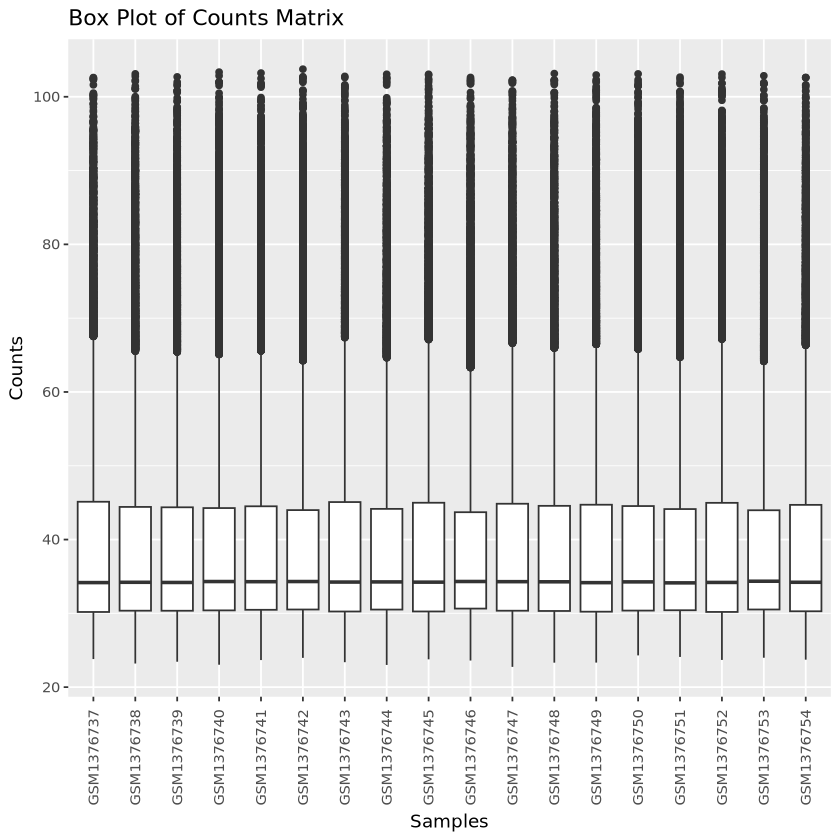

In [43]:
# Create a box plot
counts_mat <- analysis
box_plot <- ggplot(data = melt(counts_mat), aes(x = Var2, y = value)) +
  geom_boxplot() +
  labs(x = "Samples", y = "Counts") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) + # Rotate x-axis labels for better readability
  ggtitle("Box Plot of Counts Matrix")

# Compute summary statistics
summary_stats <- apply(counts_mat, 2, summary)
formatted_summary <- t(round(summary_stats, 2))
box_plot

In [44]:
dir.create("CSU_skin_MicroArray_GSE57178", showWarnings = FALSE)
saveRDS(analysis, file = file.path("CSU_skin_MicroArray_GSE57178", "expression.rds"))
saveRDS(pdata, file = file.path("CSU_skin_MicroArray_GSE57178", "metadata.rds"))

In [45]:
system("R -e \"shiny::runApp('CSU_skin_MicroArray_GSE57178')\"")